# Credit Card Fraud Detection (Unsupervised ML)

**Goal.** Detect credit-card fraud (binary supervised/unsupervised classification) and choose an operating **threshold** that balances analyst workload and missed fraud.

**Primary metric:** PR‑AUC (class imbalance) with Classification Report.

**Portable notebooks:** Download creditcard.csv from below link and keep the file at the same path level as ipynb file. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## Data Loading

In [39]:
# === Core ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Modeling / CV / Metrics ===
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    average_precision_score, roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, IsolationForest

# === Utilities ===
from joblib import Memory
from scipy.stats import randint, uniform
from sklearn.base import clone
  
df = pd.read_csv('creditcard.csv')
print(f" Total dataframe size: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")



 Total dataframe size: 67.36 MB


# Data Cleaning

In [40]:
df.rename(columns={"Class": "IsFraud"}, inplace=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,IsFraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Time     284807 non-null  float64
 1   V1       284807 non-null  float64
 2   V2       284807 non-null  float64
 3   V3       284807 non-null  float64
 4   V4       284807 non-null  float64
 5   V5       284807 non-null  float64
 6   V6       284807 non-null  float64
 7   V7       284807 non-null  float64
 8   V8       284807 non-null  float64
 9   V9       284807 non-null  float64
 10  V10      284807 non-null  float64
 11  V11      284807 non-null  float64
 12  V12      284807 non-null  float64
 13  V13      284807 non-null  float64
 14  V14      284807 non-null  float64
 15  V15      284807 non-null  float64
 16  V16      284807 non-null  float64
 17  V17      284807 non-null  float64
 18  V18      284807 non-null  float64
 19  V19      284807 non-null  float64
 20  V20      284807 non-null  

In [42]:

print('number of duplicate rows before cleanup', df.duplicated().sum())
df = df.drop_duplicates()
print('number of duplicate rows after cleanup', df.duplicated().sum())
print('Number of NaNs', df.isna().sum().sum())



number of duplicate rows before cleanup 1081
number of duplicate rows after cleanup 0
Number of NaNs 0


# Exploratory Data Analysis (EDA)

## Fraud vs Non-Fraud dataset is highly imbalanced. 
We can randomly remove almost all the transactions which are non-fraud and just keep anywhere between 473 to 2000 transations from df to make this a balanced dataset and get amazing precision and recalls numbers but that would not replicate real life situation and hence I am not doing it here.

In [43]:
print('Non-Fraud(0) vs Fraud(1) Row Count for', df['IsFraud'].value_counts())

Non-Fraud(0) vs Fraud(1) Row Count for IsFraud
0    283253
1       473
Name: count, dtype: int64


Hist was necessary over here to observe that all the features between V1 and V28 are normally distributed and they are!

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

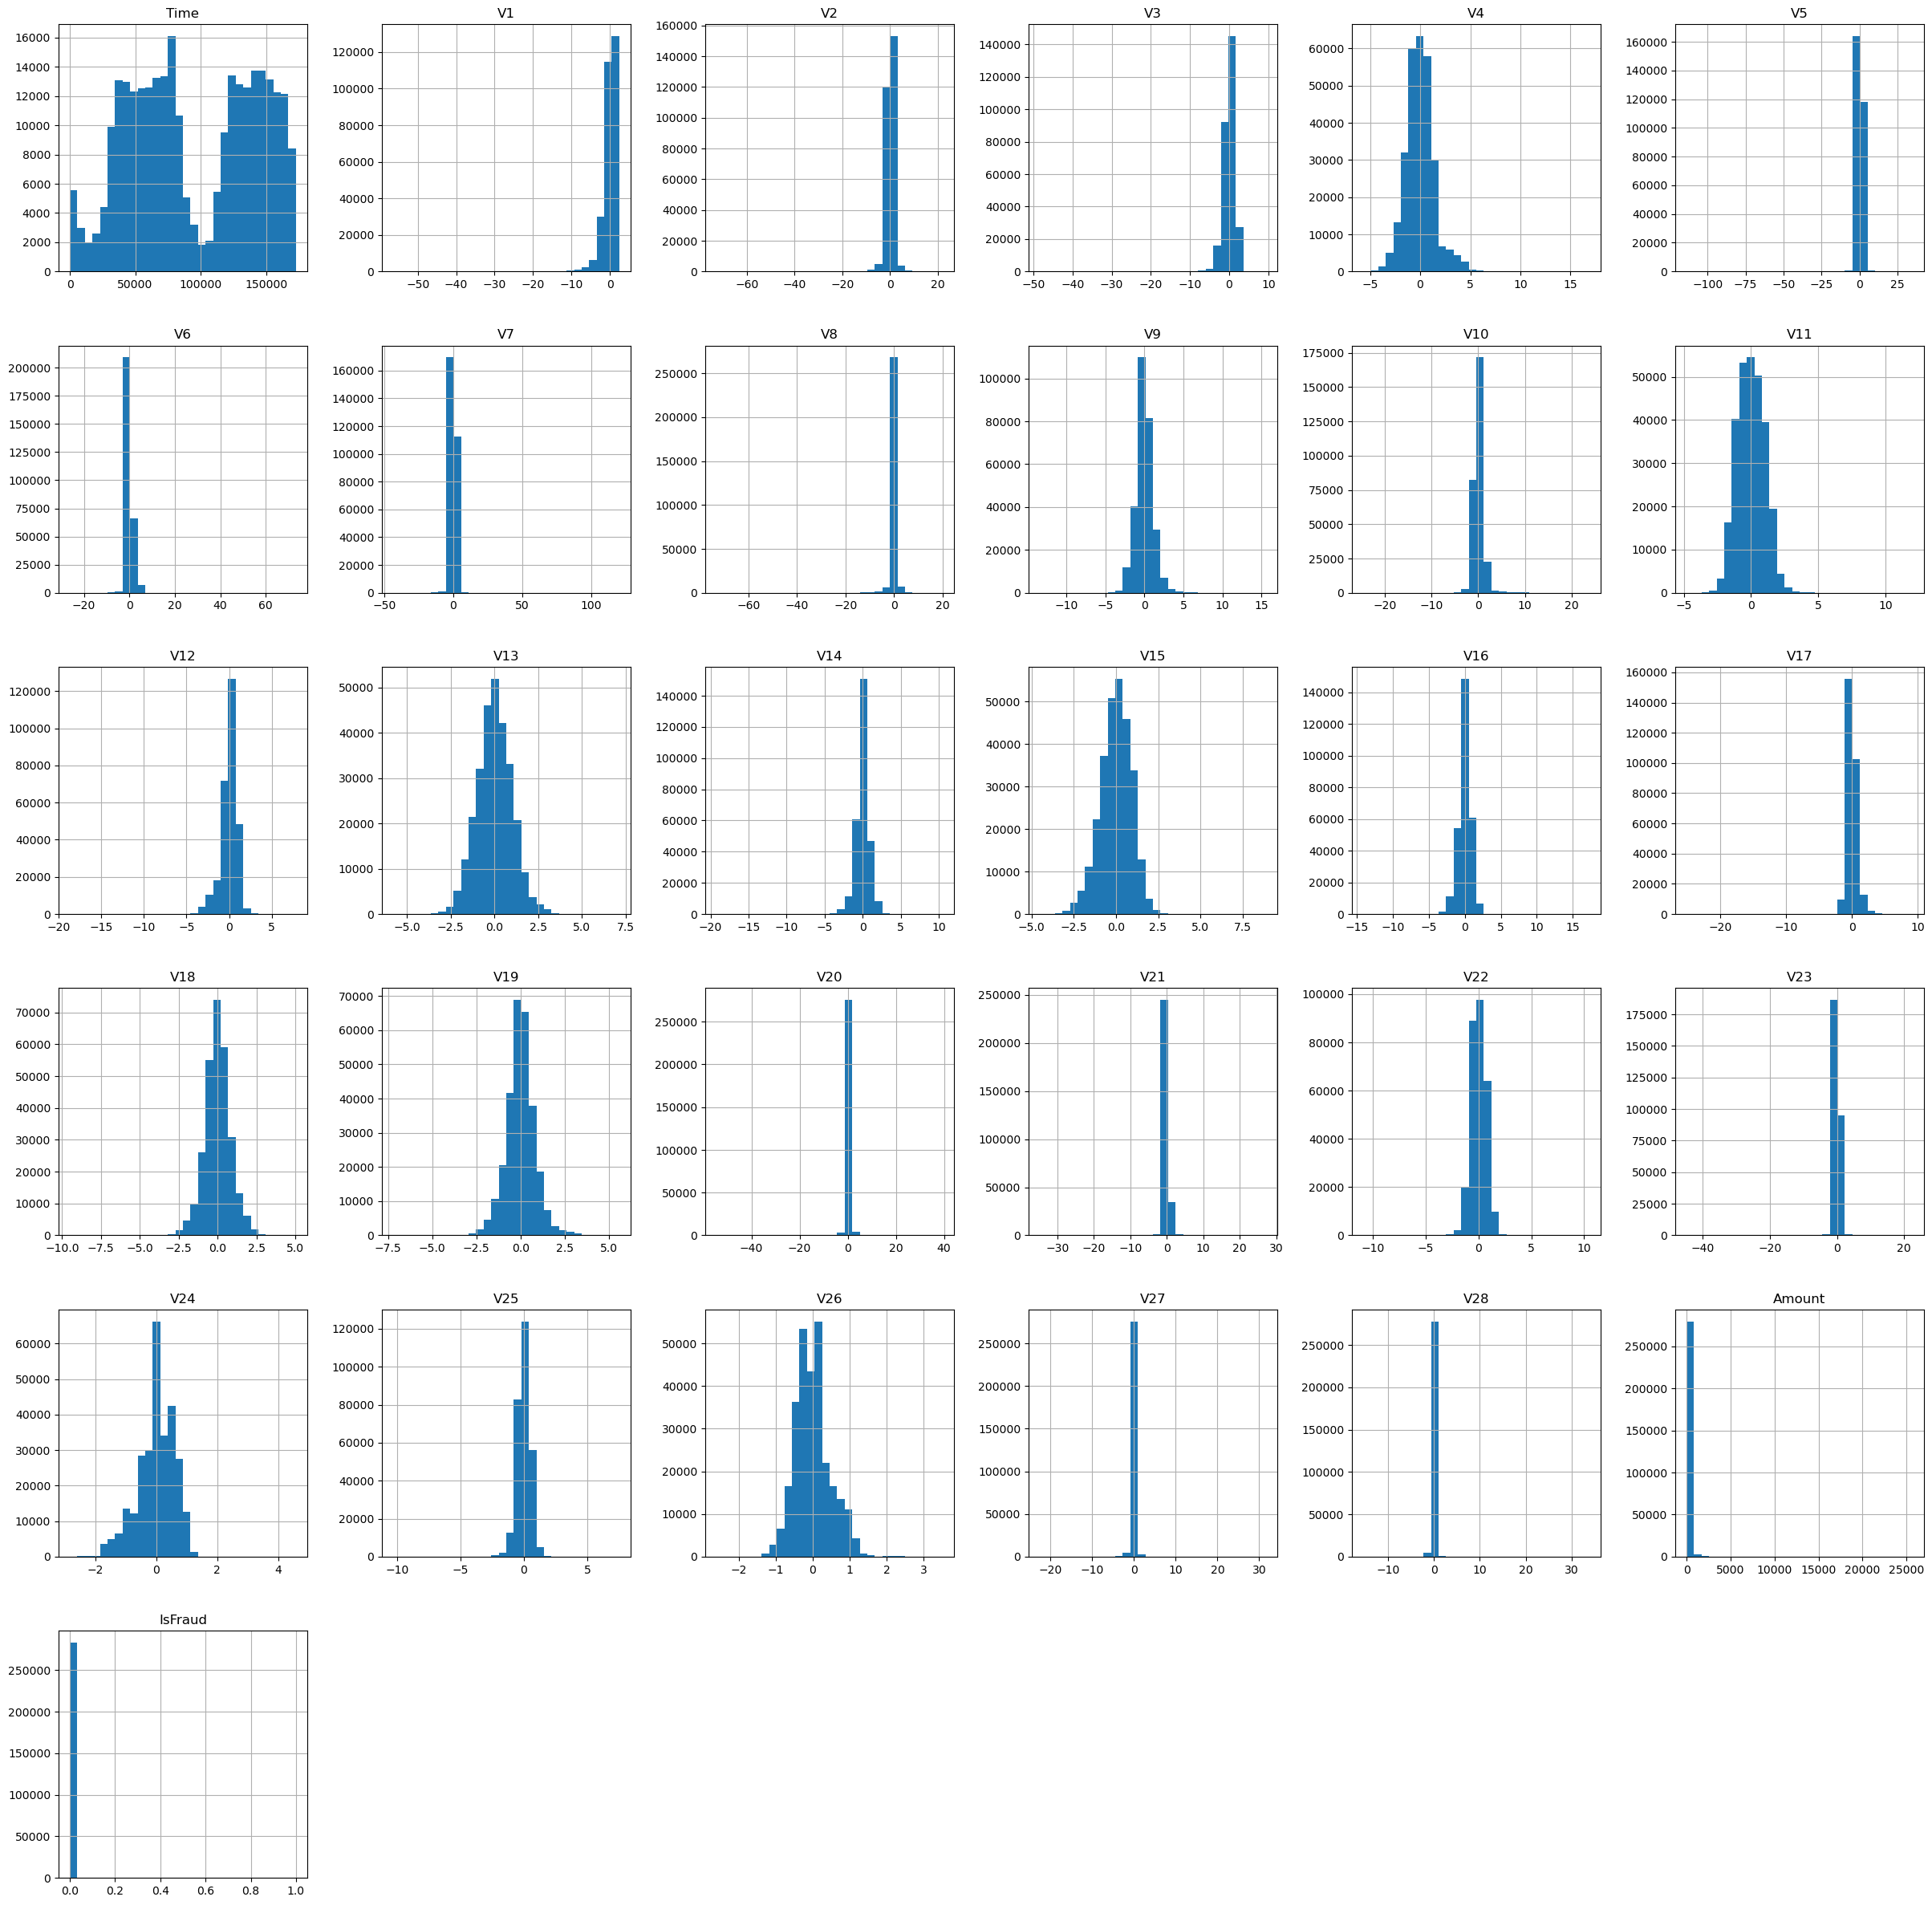

In [44]:
df.hist(bins=30, figsize=(30,30))

# Models

## Feature Engineering

Amount is not normally distributed and feature engineering is needed.

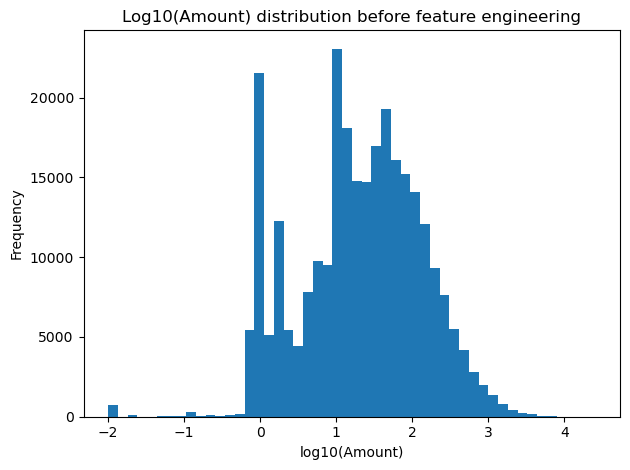

In [45]:
amt = df["Amount"].values
amt = amt[amt>0]
plt.figure()
plt.hist(np.log10(amt), bins=50)
plt.title("Log10(Amount) distribution before feature engineering")
plt.xlabel("log10(Amount)"); 
plt.ylabel("Frequency")
plt.tight_layout(); 
plt.show(); 

In [46]:
from sklearn.preprocessing import RobustScaler
if "Amount" in df.columns:
    # No negative amounts in this dataset; if any appear, cap at 0
    df.loc[df["Amount"] < 0, "Amount"] = 0
    q_low, q_high = df["Amount"].quantile((0.001, 0.999))
    df["Amount"] = df["Amount"].clip(q_low, q_high)

    # Robust scale (less sensitive to outliers)
    df["Amount"] = RobustScaler().fit_transform(df[["Amount"]])

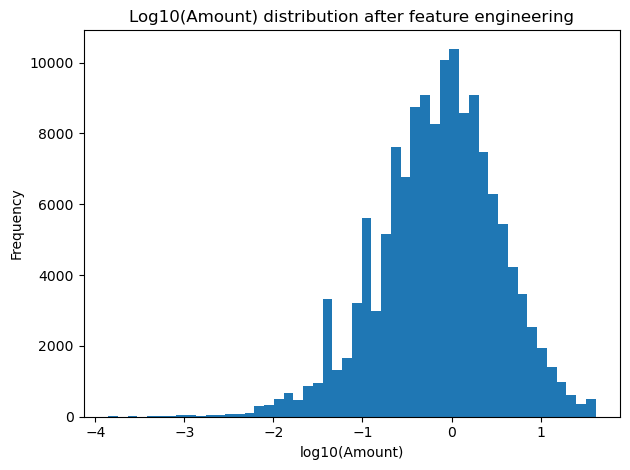

In [47]:
amt = df["Amount"].values
amt = amt[amt>0]
plt.figure()
plt.hist(np.log10(amt), bins=50)
plt.title("Log10(Amount) distribution after feature engineering")
plt.xlabel("log10(Amount)"); 
plt.ylabel("Frequency")
plt.tight_layout(); 
plt.show(); 

## Multicollinearity
Multicollinearity is not a concern. No feature pairs exceed |0.95| correlation. VIFs are below 10 (max ≈ 5.85 for Amount). Since V1..V28 are PCA-derived and near-orthogonal, we retain all features.

In [48]:
# === Collinearity checks ===
num_cols = [c for c in df.columns if c != "Class" and pd.api.types.is_numeric_dtype(df[c])]

# (a) quick correlation scan
corr = df[num_cols].corr(numeric_only=True).abs()
high_pairs = [(i,j,corr.loc[i,j]) for i in num_cols for j in num_cols if i<j and corr.loc[i,j] > 0.95]
print("Highly correlated (>|0.95|):", high_pairs[:12])

# (b) VIF on numeric (flag >10)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

Xv = df[num_cols].copy().fillna(df[num_cols].median())
Xv = pd.DataFrame(StandardScaler().fit_transform(Xv), columns=num_cols)
vif = pd.DataFrame({"feature": num_cols,
                    "VIF": [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]})\
      .sort_values("VIF", ascending=False)
vif.head(15)

Highly correlated (>|0.95|): []


,feature,VIF
29,Amount,5.854501
2,V2,2.657176
30,IsFraud,2.026203
0,Time,1.884513
5,V5,1.804948
7,V7,1.790266
20,V20,1.685384
3,V3,1.634249
1,V1,1.307776
6,V6,1.236344


## Dataset split - Train and Test

In [49]:
X = df.drop(columns='IsFraud')
y = df['IsFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
baseline = float((y_test==1).mean())
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((226980, 30), (226980,), (56746, 30), (56746,))

## Using 2 models. (RandomForestClassifier and HistGradientBoostingClassifier)

## RandomForestClassifier Hyperparameter tuning (PR-AUC)

In [50]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
memory = Memory("./.skcache", verbose=0)

rf_pipe = Pipeline([
                    ('clf', RandomForestClassifier(
                        class_weight='balanced_subsample', random_state=42, n_jobs=-1
                    ))],
                   memory=memory)

rf_params = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [8, 12, None],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"],
    "clf__max_samples": [0.6, 0.8, 1.0],
}

rf_search = RandomizedSearchCV(
    rf_pipe, rf_params, n_iter=12, scoring="average_precision",
    cv=cv, n_jobs=-1, verbose=1, random_state=42
)
rf_search.fit(X_train, y_train)   
best_rf = rf_search.best_estimator_

best_rf.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(memory=Memory(location=./.skcache/joblib),
         steps=[('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_samples=0.8, min_samples_leaf=2,
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])

## RandomForestClassifier Hyperparameter Summary

In [51]:
print("Best params:", rf_search.best_params_)
print("Best CV AP (mean):", rf_search.best_score_)

cv_summary = (pd.DataFrame(rf_search.cv_results_)
                .sort_values("mean_test_score", ascending=False)
                [["params","mean_test_score","std_test_score","rank_test_score"]]
                .head(10))
cv_summary

Best params: {'clf__n_estimators': 400, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.8, 'clf__max_features': 'sqrt', 'clf__max_depth': None}
Best CV AP (mean): 0.8381778919288528


,params,mean_test_score,std_test_score,rank_test_score
10,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.838178,0.009142,1
11,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.834786,0.010912,2
3,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.832497,0.013331,3
4,"{'clf__n_estimators': 200, 'clf__min_samples_l...",0.826516,0.015909,4
0,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.826489,0.010461,5
7,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.824619,0.010028,6
8,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.824450,0.007708,7
5,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.822965,0.014376,8
2,"{'clf__n_estimators': 200, 'clf__min_samples_l...",0.808144,0.007759,9
9,"{'clf__n_estimators': 400, 'clf__min_samples_l...",0.807157,0.018861,10


## RandomForestClassifier Model Validation with Test Dataset

Chosen threshold (val): 0.2348
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56659
       Fraud       0.84      0.80      0.82        87

    accuracy                           1.00     56746
   macro avg       0.92      0.90      0.91     56746
weighted avg       1.00      1.00      1.00     56746

RandomForest: ROC-AUC=0.9022, PR-AUC=0.6789


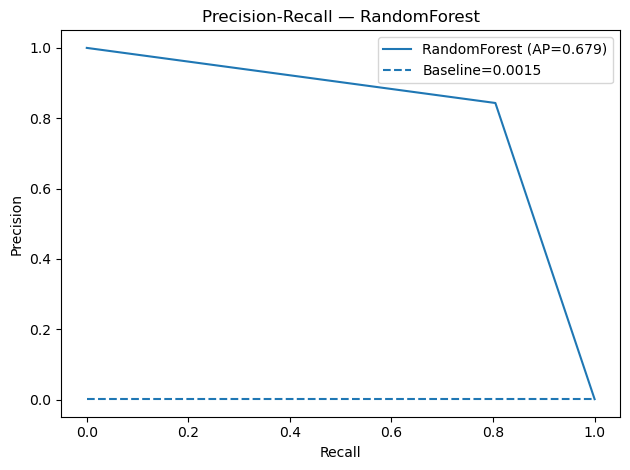

In [52]:

def summarize_model(name, y_true, y_proba, baseline_prevalence=None):
    roc = roc_auc_score(y_true, y_proba)
    pr  = average_precision_score(y_true, y_proba)

    print(f"{name}: ROC-AUC={roc:.4f}, PR-AUC={pr:.4f}")
    prec, rec, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(); 
    plt.plot(rec, prec, label=f"{name} (AP={pr:.3f})")
    if baseline_prevalence is not None:
        plt.hlines(baseline_prevalence, xmin=0, xmax=1, linestyles='dashed', label=f"Baseline={baseline_prevalence:.4f}")
    plt.xlabel("Recall"); 
    plt.ylabel("Precision"); 
    plt.title(f"Precision-Recall — {name}")
    plt.legend(); plt.tight_layout(); 
    plt.show(); 
    plt.close()

# Model predict with test dataset
proba_test = best_rf.predict_proba(X_test)[:,1]

prec, rec, thr = precision_recall_curve(y_test, proba_test)
TARGET_RECALL = 0.80
mask = rec[:-1] >= TARGET_RECALL
thr_star = thr[mask][np.argmax(prec[:-1][mask])] if mask.any() else 0.0
print("Chosen threshold (val):", round(thr_star, 4))

y_pred_test = (proba_test >= thr_star).astype(int)
print(classification_report(y_test, y_pred_test,
      target_names=["Non-Fraud","Fraud"]))
m_rf = summarize_model("RandomForest", y_test, y_pred_test, baseline_prevalence=baseline)


## HistGradientBoostingClassifier Hyperparameter tuning (PR-AUC)

In [53]:
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import randint, uniform

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
spw = max(1.0, neg / max(1, pos))
sw_train = (y_train * (spw - 1) + 1).to_numpy()  # 1 for neg, spw for pos
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

hgb_base = HistGradientBoostingClassifier(
    random_state=42,
    loss="log_loss",
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=50
)

param_dist = {
    "learning_rate":     uniform(0.02, 0.15),
    "max_leaf_nodes":    randint(15, 63),
    "max_depth":         [None, 4, 6, 8, 10],
    "min_samples_leaf":  randint(10, 200),
    "l2_regularization": uniform(0.0, 1.0),
    "max_bins":          randint(128, 255),
}

hgb_search = RandomizedSearchCV(
    hgb_base, param_dist,
    n_iter=20, scoring="average_precision", cv=cv,
    n_jobs=-1, verbose=1, random_state=42
)

hgb_search.fit(X_train, y_train, sample_weight=sw_train)
best_hgb = hgb_search.best_estimator_
print("Best params:", hgb_search.best_params_)
print("Best CV AP:", hgb_search.best_score_)




Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'l2_regularization': 0.9394989415641891, 'learning_rate': 0.15422410256414731, 'max_bins': 141, 'max_depth': 8, 'max_leaf_nodes': 54, 'min_samples_leaf': 91}
Best CV AP: 0.8424056776944933


## HistGradientBoostingClassifier Model Validation with Test Dataset

Chosen threshold (VAL): 0.2348
TEST AP: 0.8045552908497736 ROC: 0.9544526612424034
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56659
       Fraud       0.75      0.82      0.78        87

    accuracy                           1.00     56746
   macro avg       0.87      0.91      0.89     56746
weighted avg       1.00      1.00      1.00     56746

Confusion matrix:
 [[56635    24]
 [   16    71]]
Review rate: 0.17 %
HistGradientBoostingClassifier: ROC-AUC=0.9078, PR-AUC=0.6102


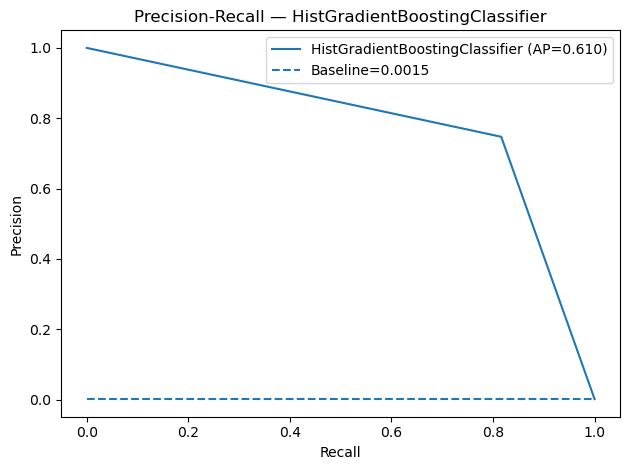

In [54]:

prec, rec, thr = precision_recall_curve(y_test, proba_test)  # thr aligns with prec[:-1], rec[:-1]
mask = rec[:-1] >= 0.80
t_star = thr[mask][np.argmax(prec[:-1][mask])] if mask.any() else 0.0
print("Chosen threshold (VAL):", round(t_star, 4))

# Model predict with test dataset
proba_test = best_hgb.predict_proba(X_test)[:, 1]
print("TEST AP:", average_precision_score(y_test, proba_test), "ROC:", roc_auc_score(y_test,  proba_test))

y_pred_test = (proba_test >= t_star).astype(int)
print(classification_report(y_test, y_pred_test, target_names=["Non-Fraud","Fraud"]))

cm = confusion_matrix(y_test, y_pred_test)
TP, FP, TN, FN = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
review_rate = (TP + FP) / len(y_test)
print("Confusion matrix:\n", cm)
print("Review rate:", round(review_rate * 100, 2), "%")
m_rf = summarize_model("HistGradientBoostingClassifier", y_test, y_pred_test, baseline_prevalence=baseline)



## Unsupervised Anomaly Detection

We fit an Isolation Forest on the raw transaction attributes to produce an anomaly score that highlights atypical behaviour without using the fraud labels.

### Hyperparameter search

We tune Isolation Forest with a small randomized search that maximizes the average precision on stratified validation folds (using the anomaly score as the decision function).

In [55]:
# Randomized search to tune Isolation Forest on anomaly-detection AP
contamination = float(y_train.mean())
iso_base = IsolationForest(
    contamination=contamination,
    random_state=42,
    n_jobs=-1,
)

max_samples_grid = [2_048, 4_096, 8_192, 16_384]
if X_train.shape[0] > 32_768:
    max_samples_grid.append(32_768)

iso_param_dist = {
    "n_estimators": randint(200, 601),
    "max_samples": max_samples_grid,
    "max_features": [0.5, 0.7, 1.0],
    "bootstrap": [False, True],
}

def isolationforest_scorer(estimator, X, y):
    scores = -estimator.decision_function(X)
    return average_precision_score(y, scores)

iso_search = RandomizedSearchCV(
    iso_base,
    param_distributions=iso_param_dist,
    n_iter=12,
    scoring=isolationforest_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
)

iso_search.fit(X_train, y_train)

print("Best params:", iso_search.best_params_)
print(f"Best CV AP: {iso_search.best_score_:.4f}")

best_iso = iso_search.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'bootstrap': False, 'max_features': 0.5, 'max_samples': 8192, 'n_estimators': 271}
Best CV AP: 0.2535


Hyperparameters inputs for the model {'contamination': 0.0017005903603841748, 'random_state': 42, 'n_jobs': -1, 'bootstrap': False, 'max_features': 0.5, 'max_samples': 8192, 'n_estimators': 271}
IsolationForest (anomaly score): ROC-AUC=0.9286, PR-AUC=0.2100


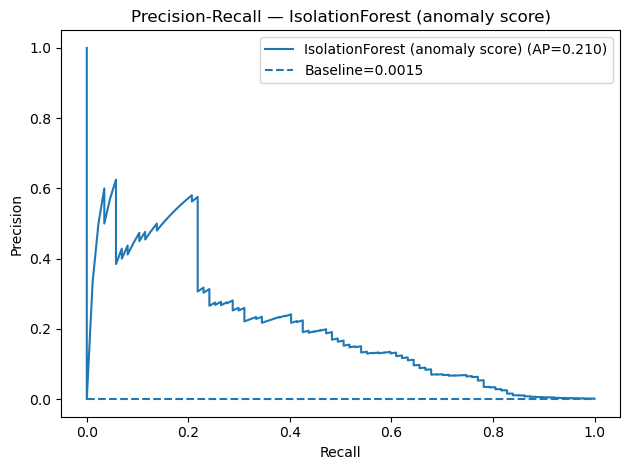

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56659
       Fraud       0.27      0.29      0.28        87

    accuracy                           1.00     56746
   macro avg       0.63      0.64      0.64     56746
weighted avg       1.00      1.00      1.00     56746



In [ ]:
# Isolation Forest trained only on the transaction covariates
contamination = float(y_train.mean())

iso_kwargs = {
    "contamination": contamination,
    "random_state": 42,
    "n_jobs": -1,
}

if 'iso_search' in globals():
    iso_kwargs.update(iso_search.best_params_)
else:
    iso_kwargs.setdefault("n_estimators", 400)
    iso_kwargs.setdefault("max_samples", min(256_000, X_train.shape[0]))
    iso_kwargs.setdefault("max_features", 1.0)
    iso_kwargs.setdefault("bootstrap", False)

# Ensure max_samples does not exceed available rows
if isinstance(iso_kwargs.get("max_samples"), int):
    iso_kwargs["max_samples"] = min(iso_kwargs["max_samples"], X_train.shape[0])
print('Hyperparameters Inputs for the model - ', iso_kwargs)
best_iso = IsolationForest(**iso_kwargs)
best_iso.fit(X_train)

iso_train_scores = -best_iso.decision_function(X_train)
iso_test_scores = -best_iso.decision_function(X_test)

summarize_model(
    "IsolationForest (anomaly score)",
    y_test,
    iso_test_scores,
    baseline_prevalence=baseline
)

iso_pred_test = (best_iso.predict(X_test) == -1).astype(int)
print(classification_report(y_test, iso_pred_test, target_names=["Non-Fraud", "Fraud"]))

### Using the anomaly score as an additional feature

The Isolation Forest score is appended to the feature matrix and the tuned Random Forest is refit to capture both supervised splits and the unsupervised notion of rarity.

RandomForest + IForest score: ROC-AUC=0.9366, PR-AUC=0.8239


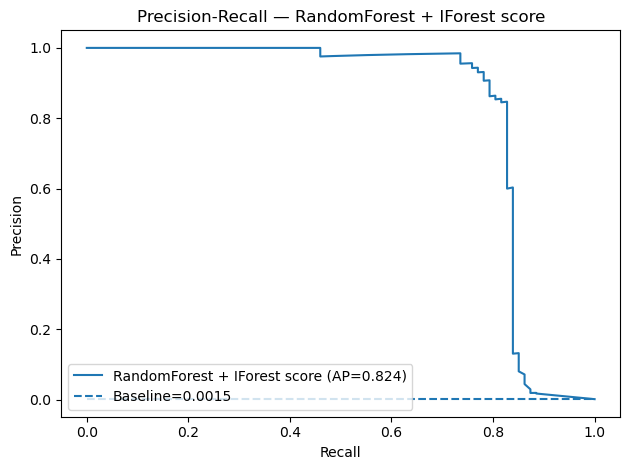

Chosen threshold (val): 0.2923
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56659
       Fraud       0.86      0.80      0.83        87

    accuracy                           1.00     56746
   macro avg       0.93      0.90      0.92     56746
weighted avg       1.00      1.00      1.00     56746



In [57]:
# Augment the supervised model with the anomaly score feature
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()
X_train_aug["IForest_score"] = iso_train_scores
X_test_aug["IForest_score"] = iso_test_scores

rf_with_unsup = clone(best_rf)
rf_with_unsup.fit(X_train_aug, y_train)

rf_proba_aug = rf_with_unsup.predict_proba(X_test_aug)[:, 1]
summarize_model(
    "RandomForest + IForest score",
    y_test,
    rf_proba_aug,
    baseline_prevalence=baseline
)

TARGET_RECALL = globals().get("TARGET_RECALL", 0.80)
prec_aug, rec_aug, thr_aug = precision_recall_curve(y_test, rf_proba_aug)
mask_aug = rec_aug[:-1] >= TARGET_RECALL
thr_aug_star = thr_aug[mask_aug][np.argmax(prec_aug[:-1][mask_aug])] if mask_aug.any() else 0.5
print("Chosen threshold (val):", round(thr_aug_star, 4))

y_pred_aug = (rf_proba_aug >= thr_aug_star).astype(int)
print(classification_report(y_test, y_pred_aug, target_names=["Non-Fraud", "Fraud"]))

# Conclusion

Our credit card dataset is understandably imbalanced since we have very few fraud transactions, our accuracy is always going to be 100% because if model predicits that the transaction is non-fraud it is going to be right most 99.9% time.

Therefore, precision and recall are very important for us to validate if the model is doing well. 

**Unsupervised ML** - I used IsolationForest (unsupervised ml) which performs poorly independently but when you combine RandomForest(supervised ml) + IsolationForest score(unsupervised ml), you get a better precision and recall as observed below.

**Precision** - 0.86 = 86% of the time model's predicition is going to be correct that a particular transaction is non-fraud and 14% of the time its going to flag transation as fraud when its not a fraud.

**Recall** - 0.80 = 80% of the time model's predicition is going to be correct that a particular transaction is fraud and 20% is the leakage where a fraud transaction will be flagged as non-fraud.

## Next steps
Machine learning is mostly the first step to run a scan to predict fraud vs non-fraud transactions. There are other robust systems in place in Banks like data reconciliation and reporting tools, technologies and processes which are out of scope for this discussion.